In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decimal import Decimal
from papermodels.paper.pdf import load_pdf_annotations
from papermodels.datatypes.geometry_graph import GeometryGraph
from papermodels.datatypes.joist_models import (
    JoistArrayModel, 
    collector_trib_model
)

In [3]:
%matplotlib inline

## 1. Create the graph

In [4]:
graph = GeometryGraph.from_pdf_file("user-applied-trib-area-arbitrary-loads.pdf", scale=Decimal(1 / 72 * 4), do_not_process=False)

# IMPORTANT!!!
# When you are working with your own trib areas and the element does NOT have any joists or collector elements transferring load
# to it then you have to be sure NOT to assign a collector behaviour (as in this example).
# If your trib element does not have any other collectors loading it then it becomes a collector element itself
# because it has no precedents in the load graph. If you assign a collector behaviour then the trib area you assigned
# will be over-written by the new collector trib area that is generated for it.
# graph.assign_collector_behaviour(collector_trib_model, as_subelements=False)

les = graph.create_loaded_elements()

## New! Page rotation correction

The page in `multi-page-plan.pdf` is rotated 270 degrees. This is performed by some PDF software to make the page "landscape" whereas other softwares set the dimensions of the page differently. If the PDF software performs a page rotation then `papermodels` will "unrotate it" as can be seen in the plot of the annotations below.

## New! Multiple "pages" on a single sheet

The `multi-page-plan.pdf` has one sheet in the PDF document that has two plan drawings on it. The lower level is on the left and the upper level is on the right. This is called "LTR" (left-to-right) convention where the plan views of the document are organized from the lowest elevations to the highest elevations in the structure. The plan views on the page should have the lowest elevations on the left.

To make sure the pages are aligned with each other, the designer must draw a "page" annotation (a rectangle with the word "page" in the text attribute) and an "origin" annotation (another smaller rectangle with the word "origin" in the text attribute). It is expected to have one origin per page. As long as the origin is drawn at the same location on the plan (i.e. the same grid intersection) such that the origin's centroid is at reference point, and that the "page rectangle" grabs all of the annotations belonging to that page, then the annotations will align across all pages.

See the PDF and see how they are interpreted as separate "pages", below.

These "virtual pages" are treated the exact same as if they were actual separate pages in the PDF. That is, the annotations will be numbered according to which "virtual page" they are on, not the PDF page.

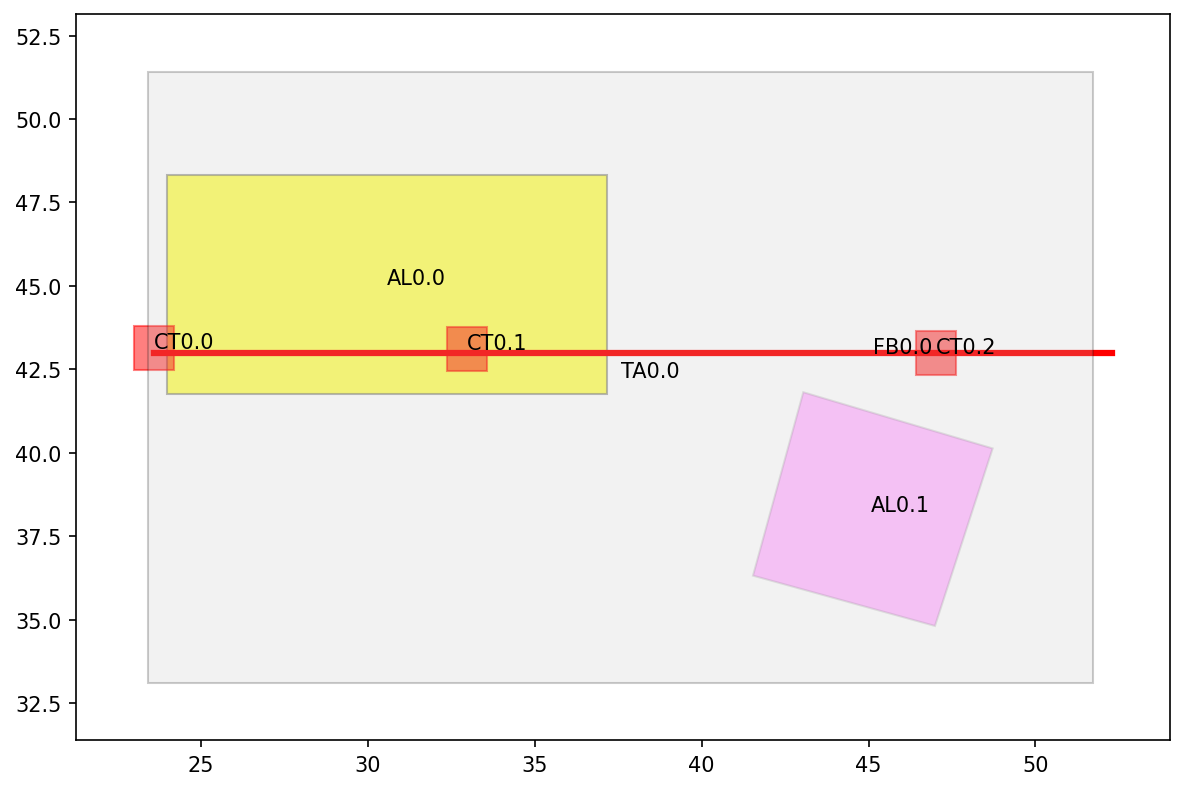

In [5]:
graph.plot_annotations(0)

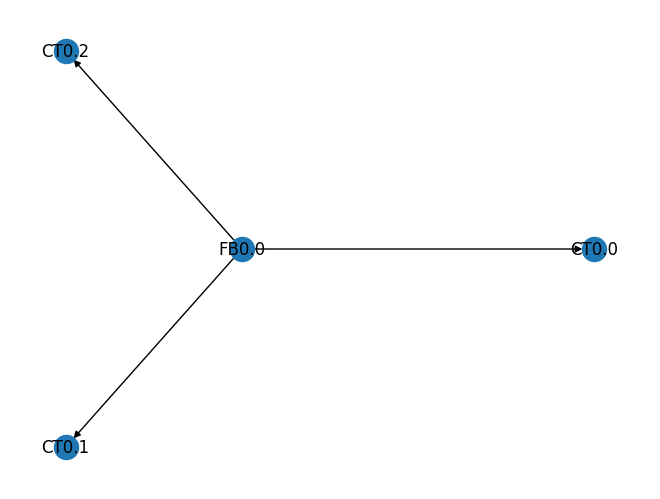

In [6]:
graph.plot_connectivity()

### Breaking change!

`LoadedElement.model(precision=3)` is now a method instead of an attribute (property). So you have to call `.model()`, not `.model`.

The new method allows for a user-defined amount of precision in the numbers. Default is 3 decimal places.

In [7]:
# See the "horz_intersects_above" and not that it does _NOT_ include "CPL0.4"
les["FB0.0"].model()

{'element_attributes': {'tag': 'FB0.0',
  'length': 13.788,
  'orientation': 'horizontal',
  'vert_correspondent_below': [],
  'vert_correspondent_above': [],
  'horz_intersects_above': [],
  'horz_intersects_below': ['CT0.0', 'CT0.1', 'CT0.2']},
 'element_geometry': {'geometry': 'LINESTRING (11.319 20.64, 25.107 20.64)',
  'supports': [{'location': 0.29, 'fixity': 'pin'},
   {'location': 4.504, 'fixity': 'roller'},
   {'location': 11.254, 'fixity': 'roller'}]},
 'loads': {'point_loads': [],
  'distributed_loads': [{'transfer_source': '',
    'transfer_reaction_index': '',
    'occupancy': 'f',
    'load_components': [],
    'applied_area': 20.036,
    'start_loc': 0.191,
    'start_magnitude': 0.158,
    'end_loc': 6.524,
    'end_magnitude': 0.158},
   {'transfer_source': '',
    'transfer_reaction_index': '',
    'occupancy': 'a',
    'load_components': [],
    'applied_area': 1.027,
    'start_loc': 8.62,
    'start_magnitude': 0.0,
    'end_loc': 9.343,
    'end_magnitude': 0.377}

In [8]:
# See how "CPL0.4" is one of the load sources for "FB0.2" instead?
# (See "horz_intersects_above" and the second point load)
les["FB0.2"].model()

KeyError: 'FB0.2'

In [7]:
# See how the weirdly shaped loads get turned into distributed loads?
les['FB0.0'].model()

{'element_attributes': {'tag': 'FB0.0',
  'length': 13.788,
  'orientation': 'horizontal',
  'vert_correspondent_below': [],
  'vert_correspondent_above': [],
  'horz_intersects_above': [],
  'horz_intersects_below': ['CT0.0', 'CT0.1', 'CT0.2']},
 'element_geometry': {'geometry': 'LINESTRING (11.319 20.64, 25.107 20.64)',
  'supports': [{'location': 0.29, 'fixity': 'pin'},
   {'location': 4.504, 'fixity': 'roller'},
   {'location': 11.254, 'fixity': 'roller'}]},
 'loads': {'point_loads': [],
  'distributed_loads': [{'transfer_source': '',
    'transfer_reaction_index': '',
    'occupancy': 'f',
    'load_components': [],
    'applied_area': 20.036,
    'start_loc': 0.191,
    'start_magnitude': 0.158,
    'end_loc': 6.524,
    'end_magnitude': 0.158},
   {'transfer_source': '',
    'transfer_reaction_index': '',
    'occupancy': 'a',
    'load_components': [],
    'applied_area': 1.027,
    'start_loc': 8.62,
    'start_magnitude': 0.0,
    'end_loc': 9.343,
    'end_magnitude': 0.377}

## 2. Output the model files

Currently outputs in either JSON or TOML. Both are equivalent to a dictionary and can be parsed by modules in the standard library, i.e. `toml`, `json`.

In [8]:
import pathlib
output_dir = pathlib.Path("model_files")

file_format = "toml" # also try "json"

for loaded_element in les.values():
    if file_format == "toml":
        output_toml = output_dir / "toml"
        output_toml.mkdir(parents=True, exist_ok=True)
        with open(output_dir / "toml" / f"{loaded_element.tag}.toml", "wb") as file:
            loaded_element.dump_toml(file, precision=4) # You can set the precision here, too
    elif file_format == "json":
        output_json = output_dir / "json"
        output_json.mkdir(parents=True, exist_ok=True)
        with open(output_dir / "json" / f"{loaded_element.tag}.json", "w") as file:
            loadeded_element.dump_json(file, precision=4) # You can set the precision here, too
        